In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import mne

import random 
import re
from tqdm import tqdm

DB_PATH = './db/v1.5.1/'

In [2]:
'''
Load data from one file
'''

file_dir = './db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23'
EVENTS_FILE = './train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse'

def data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None

seiz_edf_name = EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_edf_file = file_dir +'/'+ seiz_edf_name
seiz_data, seiz_freq = data_load(seiz_edf_file)

print(seiz_edf_file)
display(seiz_data.shape)

./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.edf


(284000, 31)

In [3]:
def mne_object(data, freq, events_tse = pd.DataFrame()):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if not events_tse.empty:

    raw.set_annotations(mne.Annotations(events_tse['Start'],
                                          events_tse['End'] - events_tse['Start'],
                                          events_tse['Code']))

  return raw

seiz_events_name = EVENTS_FILE.split('/')[-1]
events_tse = pd.read_csv(file_dir+'/'+seiz_events_name, 
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])

tuh_mne = mne_object(seiz_data, seiz_freq, events_tse)

print(file_dir+'/'+seiz_events_name)

Creating RawArray with float64 data, n_channels=31, n_times=284000
    Range : 0 ... 283999 =      0.000 ...  1135.996 secs
Ready.
./db/v1.5.1/edf/train/01_tcp_ar/091/00009104/s006_2014_09_23/00009104_s006_t002.tse


Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



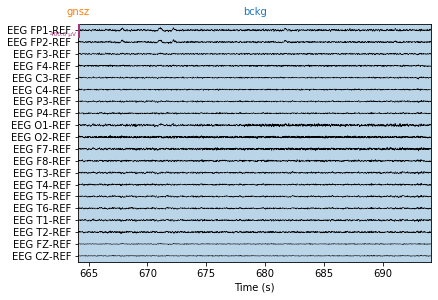

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



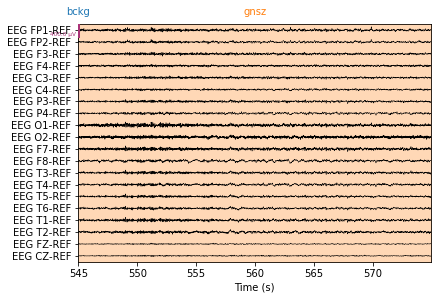

In [47]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}


for class_code in events_tse['Code'].unique():
    code_events = events_tse.where(events_tse['Code'] == class_code).dropna()
    fig = tuh_mne.plot(start = code_events.sample(random_state = 0)['Start'].values[0], 
                    duration = 30, **plot_kwargs)
    

In [5]:
# Get similar channels
channel_keeps = ['EEG F8-REF', 'EEG T5-REF', 'EEG F7-REF', 'EEG FP1-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG FZ-REF', 'EEG T4-REF', 'EEG O2-REF', 'EEG F3-REF', 'EEG T6-REF', 'EEG CZ-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG C4-REF', 'EEG T3-REF', 'EEG PZ-REF', 'EEG F4-REF', 'EEG C3-REF']


print(channel_keeps)

['EEG F8-REF', 'EEG T5-REF', 'EEG F7-REF', 'EEG FP1-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG FZ-REF', 'EEG T4-REF', 'EEG O2-REF', 'EEG F3-REF', 'EEG T6-REF', 'EEG CZ-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG C4-REF', 'EEG T3-REF', 'EEG PZ-REF', 'EEG F4-REF', 'EEG C3-REF']


In [6]:
ATT_START = 0
ATT_END = 0

import chardet
def create_events(file_name, df, code = None):

    data_y = pd.Series(index=df.index)
    data_y.name = 'Events'
    
    events_tse = pd.read_csv(file_name,
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])
    
    data_y = data_y.fillna('bckg')
    
    
    for pos, row in events_tse.iterrows():
        # if you want to manually set the code
        if code != None:
          if row['Code'] == code:
              data_y[row['Start']:row['End']] = code
        # let it be the code it is in the event file
        else:
          data_y[row['Start']:row['End']] = row['Code']

    return data_y

In [7]:
# Read files into df and create events series

file_ID = EVENTS_FILE.split('/')[-1][:-4]
# we use the above to get the file directory this file is in
pat_file_dir = 'edf/' + '/'.join(EVENTS_FILE.split('/')[1:-1])
   
file_path = DB_PATH+pat_file_dir+'/'+file_ID+'.edf'
#print(file_path)
pat_ID = EVENTS_FILE.split('/')[-3]

# load data
raw_data, freq = data_load(file_path, channel_keeps)
   
if raw_data.empty:
    print('Skipped: '+file_ID)
else:
    raw_events = create_events(DB_PATH+pat_file_dir+'/'+file_ID+'.tse', raw_data)
    # change to integer representation
    #raw_events = raw_events.replace(int_code)


<ipython-input-6-000e68478807>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_y = pd.Series(index=df.index)


In [8]:
# Replace labels in pd series, 0 for no seizure and 1 for seizure
raw_events = raw_events.replace('bckg',0)
raw_events = raw_events.replace('gnsz',1)

print(raw_events)
display(raw_data)

Time
0.000       0
0.004       0
0.008       0
0.012       0
0.016       0
           ..
1135.980    0
1135.984    0
1135.988    0
1135.992    0
1135.996    0
Name: Events, Length: 284000, dtype: int64


Channel,EEG F8-REF,EEG T5-REF,EEG F7-REF,EEG FP1-REF,EEG P3-REF,EEG P4-REF,EEG FZ-REF,EEG T4-REF,EEG O2-REF,EEG F3-REF,EEG T6-REF,EEG CZ-REF,EEG FP2-REF,EEG O1-REF,EEG C4-REF,EEG T3-REF,EEG PZ-REF,EEG F4-REF,EEG C3-REF
Time,,,,,,,,,,,,,,,,,,,
0.000,-19.738714,-5.182645,-35.131339,-25.259982,1.175178,2.848289,-27.100404,-7.525001,-35.633272,-45.002696,0.840556,-10.369290,-18.400225,-59.056831,-7.859623,-13.213580,-5.182645,-24.925359,-28.271582
0.004,-17.229047,8.034935,-23.084937,-23.586870,13.556202,12.217713,-33.290916,2.011734,-21.579137,-42.325717,14.727380,-4.680712,-22.917626,-46.675807,-5.851890,0.171311,4.521401,-29.442760,-21.746448
0.008,-11.373157,19.412092,-16.894425,-22.081070,20.415959,17.404358,-33.290916,10.377290,-14.552069,-38.979495,24.598737,1.175178,-20.909892,-29.610071,-1.836422,10.711913,11.548468,-28.606204,-14.552069
0.012,-14.217447,15.396625,-24.088804,-28.271582,16.400491,15.731247,-35.800583,8.202246,-17.563669,-48.516229,21.419825,-1.501800,-19.236781,-42.493029,0.505933,6.361823,7.700312,-31.450494,-21.077203
0.016,-12.711646,5.357956,-29.777382,-31.115871,6.529134,10.879224,-32.454360,3.350223,-8.361557,-50.691274,12.552335,-6.019201,-16.225180,-49.520096,3.015600,-3.007600,0.673245,-26.263848,-27.435026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135.980,-28.606204,-21.077203,-32.956294,-2.505667,-24.088804,-8.194246,-22.583003,-15.388625,-29.442760,-26.765782,-10.034668,-27.100404,-40.819917,-42.493029,-18.734847,-34.796716,-26.765782,-13.380891,-26.431160
1135.984,-32.119738,-26.933093,-38.310250,-35.131339,-26.096537,-15.054002,-21.244514,-20.407959,-32.788983,-13.882824,-17.229047,-29.610071,-41.321851,-23.419559,-20.909892,-39.983362,-31.115871,-16.727114,-31.283182
1135.988,-28.940827,-25.929226,-35.967894,-10.536602,-20.742581,-16.894425,-21.077203,-21.746448,-28.271582,-14.217447,-18.400225,-28.104271,-15.221313,-13.380891,-19.906025,-36.135205,-29.610071,-34.796716,-24.590737


In [9]:
# Change to an array
data_X = raw_data.values
data_y = raw_events.values

print(len(data_X))
display( data_X)
print(len(data_y))
display(data_y)

284000


array([[-19.73871407,  -5.18264522, -35.1313386 , ...,  -5.18264522,
        -24.92535929, -28.27158202],
       [-17.22904703,   8.03493454, -23.0849368 , ...,   4.52140068,
        -29.44275997, -21.74644771],
       [-11.37315726,  19.4120918 , -16.89442476, ...,  11.5484684 ,
        -28.60620429, -14.55206885],
       ...,
       [-28.94082656, -25.92922611, -35.96789428, ..., -29.61007111,
        -34.79671633, -24.59073702],
       [-27.43502634, -26.09653725, -39.31411701, ..., -30.61393793,
        -46.84311814, -20.90989203],
       [-21.2445143 , -24.08880361, -27.93695975, ..., -28.77351543,
        -39.31411701, -22.08106998]])

284000


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [10]:
# Extacts the timestamps where a seizure is present
seizure_index = raw_events[raw_events == 1].index

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=20)

seizure_index.values

array([544.98 , 544.984, 544.988, ..., 664.108, 664.112, 664.116])

In [11]:
for index, val in raw_events.iteritems():
    if(val == 1):
        print(index, val)
        break

544.98 1


In [12]:
interictal = []
ictal = []

count = 0
for index, row in raw_data.iterrows():
    if(index in seizure_index):
        #print(index)
        #print(row.values)
        ictal.append(row.values)
        #ictal = np.vstack([ictal, row.values])
    else:
        interictal.append(row.values)
        
interictal_np = np.array(interictal)
ictal_np = np.array(ictal) 

In [13]:
np.set_printoptions(threshold=20)

print(ictal_np)
print(len(ictal_np))

[[  8.53686795 -20.40795862 -24.08880361 ... -21.41182543 -16.39249135
  -16.22518021]
 [ -5.01533409 -27.43502634 -26.26384838 ... -25.92922611 -14.71937999
  -15.22131339]
 [-13.8828243  -25.4272927  -26.26384838 ... -26.93309293 -19.23678066
  -15.89055794]
 ...
 [-15.38862453 -26.26384838  -6.0192009  ... -17.73098044 -25.25998157
   -9.86735704]
 [-16.39249135 -23.75418134  -0.83255568 ... -19.06946953 -22.91762566
  -11.70777953]
 [-17.22904703 -18.73484725   1.50980023 ... -20.74258089 -19.90602521
  -14.88669112]]
29785


In [14]:
'''
    MAtrix form
'''
WINDOW_LENGTH = 20 # in seconds 
WINDOW_LENGTH_MS = WINDOW_LENGTH * 250

interictal_train = []
ictal_train = []

y_train = []

# Interictal train
for i in range(100):
    end_index = random.randint(WINDOW_LENGTH_MS, len(interictal_np))
    start_index = end_index - WINDOW_LENGTH_MS

    interictal_train.append(interictal_np[start_index:end_index])
    y_train.append([0])

# Ictal train
for i in range(100):
    end_index = random.randint(WINDOW_LENGTH_MS, len(ictal_np))
    start_index = end_index - WINDOW_LENGTH_MS

    ictal_train.append(ictal_np[start_index:end_index])
    y_train.append([1])

interictal_test = []
ictal_test = []

y_test = []

# Interictal test
for i in range(50):
    end_index = random.randint(WINDOW_LENGTH_MS, len(interictal_np))
    start_index = end_index - WINDOW_LENGTH_MS
    
    interictal_test.append(interictal_np[start_index:end_index])
    y_test.append([0])

# Ictal test
for i in range(50):
    end_index = random.randint(WINDOW_LENGTH_MS, len(ictal_np))
    start_index = end_index - WINDOW_LENGTH_MS
    
    ictal_test.append(ictal_np[start_index:end_index])
    y_test.append([1])


In [15]:

WINDOW_LENGTH = 20 # in seconds 
WINDOW_LENGTH_MS = WINDOW_LENGTH * 250

interictal_train = []
ictal_train = []

y_train = []

# Interictal train
for i in range(100):
    end_index = random.randint(WINDOW_LENGTH_MS, len(interictal_np))
    start_index = end_index - WINDOW_LENGTH_MS

    interictal_train.append(interictal_np[start_index:end_index].flatten())
    y_train.append([0])

# Ictal train
for i in range(100):
    end_index = random.randint(WINDOW_LENGTH_MS, len(ictal_np))
    start_index = end_index - WINDOW_LENGTH_MS

    ictal_train.append(ictal_np[start_index:end_index].flatten())
    y_train.append([1])

interictal_test = []
ictal_test = []

y_test = []

# Interictal test
for i in range(50):
    end_index = random.randint(WINDOW_LENGTH_MS, len(interictal_np))
    start_index = end_index - WINDOW_LENGTH_MS
    
    interictal_test.append(interictal_np[start_index:end_index].flatten())
    y_test.append([0])

# Ictal test
for i in range(50):
    end_index = random.randint(WINDOW_LENGTH_MS, len(ictal_np))
    start_index = end_index - WINDOW_LENGTH_MS
    
    ictal_test.append(ictal_np[start_index:end_index].flatten())
    y_test.append([1])


In [16]:
X_train = interictal_train + ictal_train

print(len(X_train))
print(X_train[0])

X_test = interictal_test + ictal_test


200
[ -0.33062227 -27.43502634  -7.8596234  ... -12.54433522  -4.51340068
 -17.22904703]


In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


print(X_train.shape)
print(y_train.shape)

(200, 95000)
(200, 1)


In [18]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # 100 neuron hidden layer
    tf.keras.layers.Dense(100, activation='relu', input_shape=(1,WINDOW_LENGTH_MS*19)),
    
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 'interictal' and 1 for 'ictal'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 100)            9500100   
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              101       
Total params: 9,500,201
Trainable params: 9,500,201
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 50

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

best_model_filepath = "Best_Model.ckpt"

# Save the model under certain conditions
callback_checkpoint = ModelCheckpoint(filepath=best_model_filepath,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_weights_only=True,
                                      save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, 
                                        verbose=1)

def create_callbacks(best_model_filepath):

    callback_checkpoint = ModelCheckpoint(filepath=best_model_filepath,
                                        monitor='val_loss',
                                        verbose=0,
                                        save_weights_only=True,
                                        save_best_only=True)
  
    callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, 
                                        verbose=1)

In [20]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

In [21]:
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(X_train, 
                    y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks= create_callbacks(best_model_filepath),
                    verbose=1)

Epoch 1/50
3/3 [==============================] - 3s 957ms/step - loss: 288.0845 - accuracy: 0.4769 - auc: 0.4866 - recall: 0.3808 - precision: 0.3862 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/50
3/3 [==============================] - 0s 92ms/step - loss: 501.7381 - accuracy: 0.4977 - auc: 0.5234 - recall: 0.8625 - precision: 0.4719 - val_loss: 1629.8599 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 101ms/step - loss: 520.4251 - accuracy: 0.5778 - auc: 0.5588 - recall: 0.1312 - precision: 0.4375 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/50
3/3 [==============================] - 0s 112ms/step - loss: 171.1433 - accuracy: 0.5898 - auc: 0.6308 - recall: 1.0000 - precision: 0.5278 - val_loss: 368.1845 - val_accuracy: 0.0000e+00

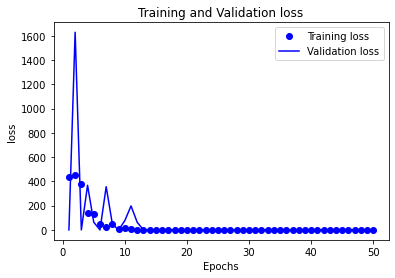

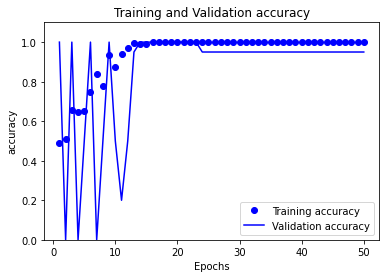

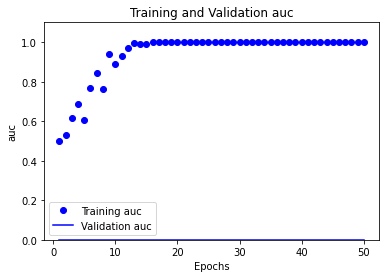

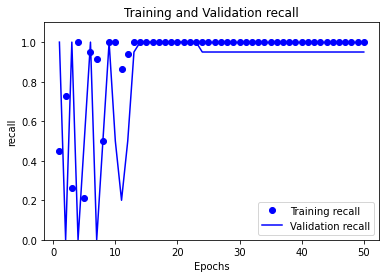

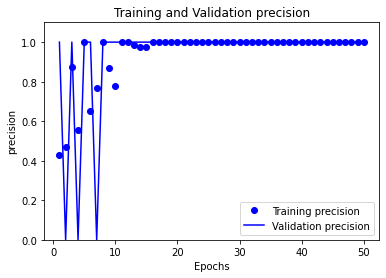

In [22]:
import matplotlib.pyplot as plt

def plot_progress(history_dict):
  for key in list(history_dict.keys())[:5]:
    plt.clf() # Clears the figure
    training_values = history_dict[key] 
    val_values = history_dict['val_'+key]

    epochs = range(1, len(training_values) + 1)

    plt.plot(epochs, training_values, 'bo', label='Training '+key)

    plt.plot(epochs, val_values, 'b', label='Validation '+key)

    if key != 'loss':
      plt.ylim([0.,1.1])

    plt.title('Training and Validation '+key) 
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.legend()
    plt.show()
    
plot_progress(history.history)